In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import boxenplot, barplot, lineplot
import nltk #type:ignore
from nltk.corpus import stopwords #type:ignore
from wordcloud import WordCloud #type:ignore
from numpy import arange

In [2]:
treasury_purchases = pd.read_csv("../data/raw/clean_treasury.csv", header=0, delimiter=",")
treasury_purchases.tail()

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,MES,DIA
1535,203016,SEGOVIA PAEZ MARCELO,SEPM8603058S7,116033-158004-1689,NO APLICA,FINIQUITO 116033,CH,1104570.0,2020-12-11,183992.72,SERV. PERS.,12,11
1536,203016,SEGOVIA PAEZ MARCELO,SEPM8603058S7,116033-158004-1690,NO APLICA,FONDO PENSIONES 116033,CH,1104571.0,2020-12-11,56430.00,SERV. PERS.,12,11
1537,203016,TORRES ACOSTA ROBERTO CARLOS,TOAR8409234Y0,113052-158004-1725,NO APLICA,FONDO DE PENSIONES 113052,CH,299000183.0,2020-12-16,7425.00,SERV. PERS.,12,16
1538,203016,TOVAR CEDILLO JAVIER ALFONSO,TOCJ750710A31,23016-158004-1705,NO APLICA,PAGO 30% JUICIO DE AMPARO No. 673/2020 (DICIE...,CH,299000179.0,2020-12-15,4084.68,SERV. PERS.,12,15
1539,203016,VILLARREAL CARDENAS NANCY ESTHER,VICN801211SM7,113711-158004-1711,NO APLICA,FONDO PENSIONES 113711,CH,1104567.0,2020-12-11,22575.00,SERV. PERS.,12,11


In [3]:
treasury_purchases.columns

Index(['NUM BEN', 'BENEFICIARIO', 'RFC', 'FACTURA', 'CONTRATO', 'CONCEPTO',
       'TIPO', '# OP', 'FECHA', 'IMPORTE', 'SHEET', 'MES', 'DIA'],
      dtype='object')

### Undimensional analysis.

`IMPORTE` is a dependent value, `OP` and `NUM BEN` are only identifiers.

In [4]:
treasury_purchases.describe()

,NUM BEN,# OP,IMPORTE,MES,DIA
count,1540.000000,1.540000e+03,1.540000e+03,1540.0,1540.000000
mean,203914.777273,1.920050e+08,6.263179e+05,12.0,13.474026
std,92435.932025,1.411189e+08,4.666912e+06,0.0,8.884647
min,110152.000000,1.019042e+06,8.600000e-01,12.0,1.000000
25%,116223.000000,1.019144e+06,2.987000e+03,12.0,4.000000
50%,203013.000000,2.980000e+08,1.235584e+04,12.0,11.000000
75%,311250.000000,3.000001e+08,1.130583e+05,12.0,22.000000
max,370012.000000,6.040001e+08,1.267303e+08,12.0,31.000000


Purchase budget seems more shifted towards `CONTRATISTAS` and `GASTOS VARIOS`.

In [5]:
treasury_purchases["SHEET"].value_counts()

CONTRATISTAS Y FDO FED    724
GASTOS VARIOS             690
COMUNICACION               71
SERV. PERS.                46
SERV PPROF                  9
Name: SHEET, dtype: int64

1396 concepts of purchase, 656 contracts, and 301 different recipients.

In [6]:
treasury_purchases["CONCEPTO"].unique().shape[0]

1396

In [7]:
treasury_purchases["BENEFICIARIO"].unique().shape[0]

301

In [8]:
treasury_purchases["CONTRATO"].unique().shape[0]

656

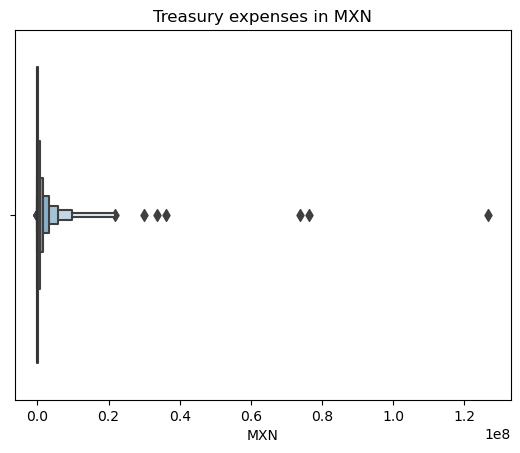

In [9]:
boxenplot(data=treasury_purchases, x="IMPORTE", showfliers=True)
plt.title("Treasury expenses in MXN")
plt.xlabel("MXN")
plt.show()

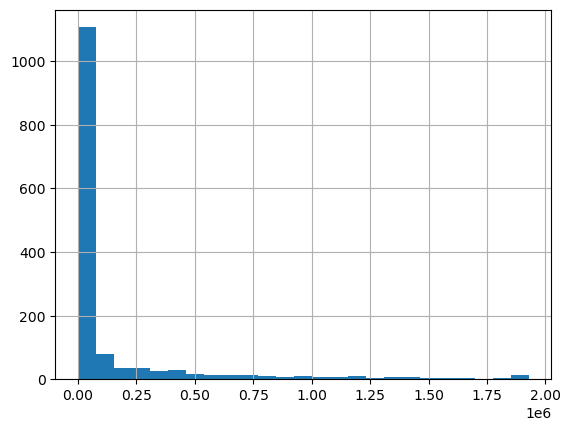

In [10]:
treasury_purchases[treasury_purchases["IMPORTE"] <= treasury_purchases["IMPORTE"].quantile(0.95)]["IMPORTE"].hist(bins=25)
plt.show()

### Multidimensional analysis.

We could analyze which are the top 10 recipients of treasury budget

In [11]:
recipients = treasury_purchases.groupby(by=["BENEFICIARIO", "SHEET"]).sum(numeric_only=True)["IMPORTE"].sort_values(ascending=False)[:10].reset_index()
contracts = treasury_purchases.groupby(by="CONTRATO").sum(numeric_only=True)["IMPORTE"].sort_values(ascending=False)[:10].reset_index()
concept_type = treasury_purchases.groupby(by="SHEET").sum(numeric_only=True)["IMPORTE"].sort_values(ascending=False)[:10].reset_index()

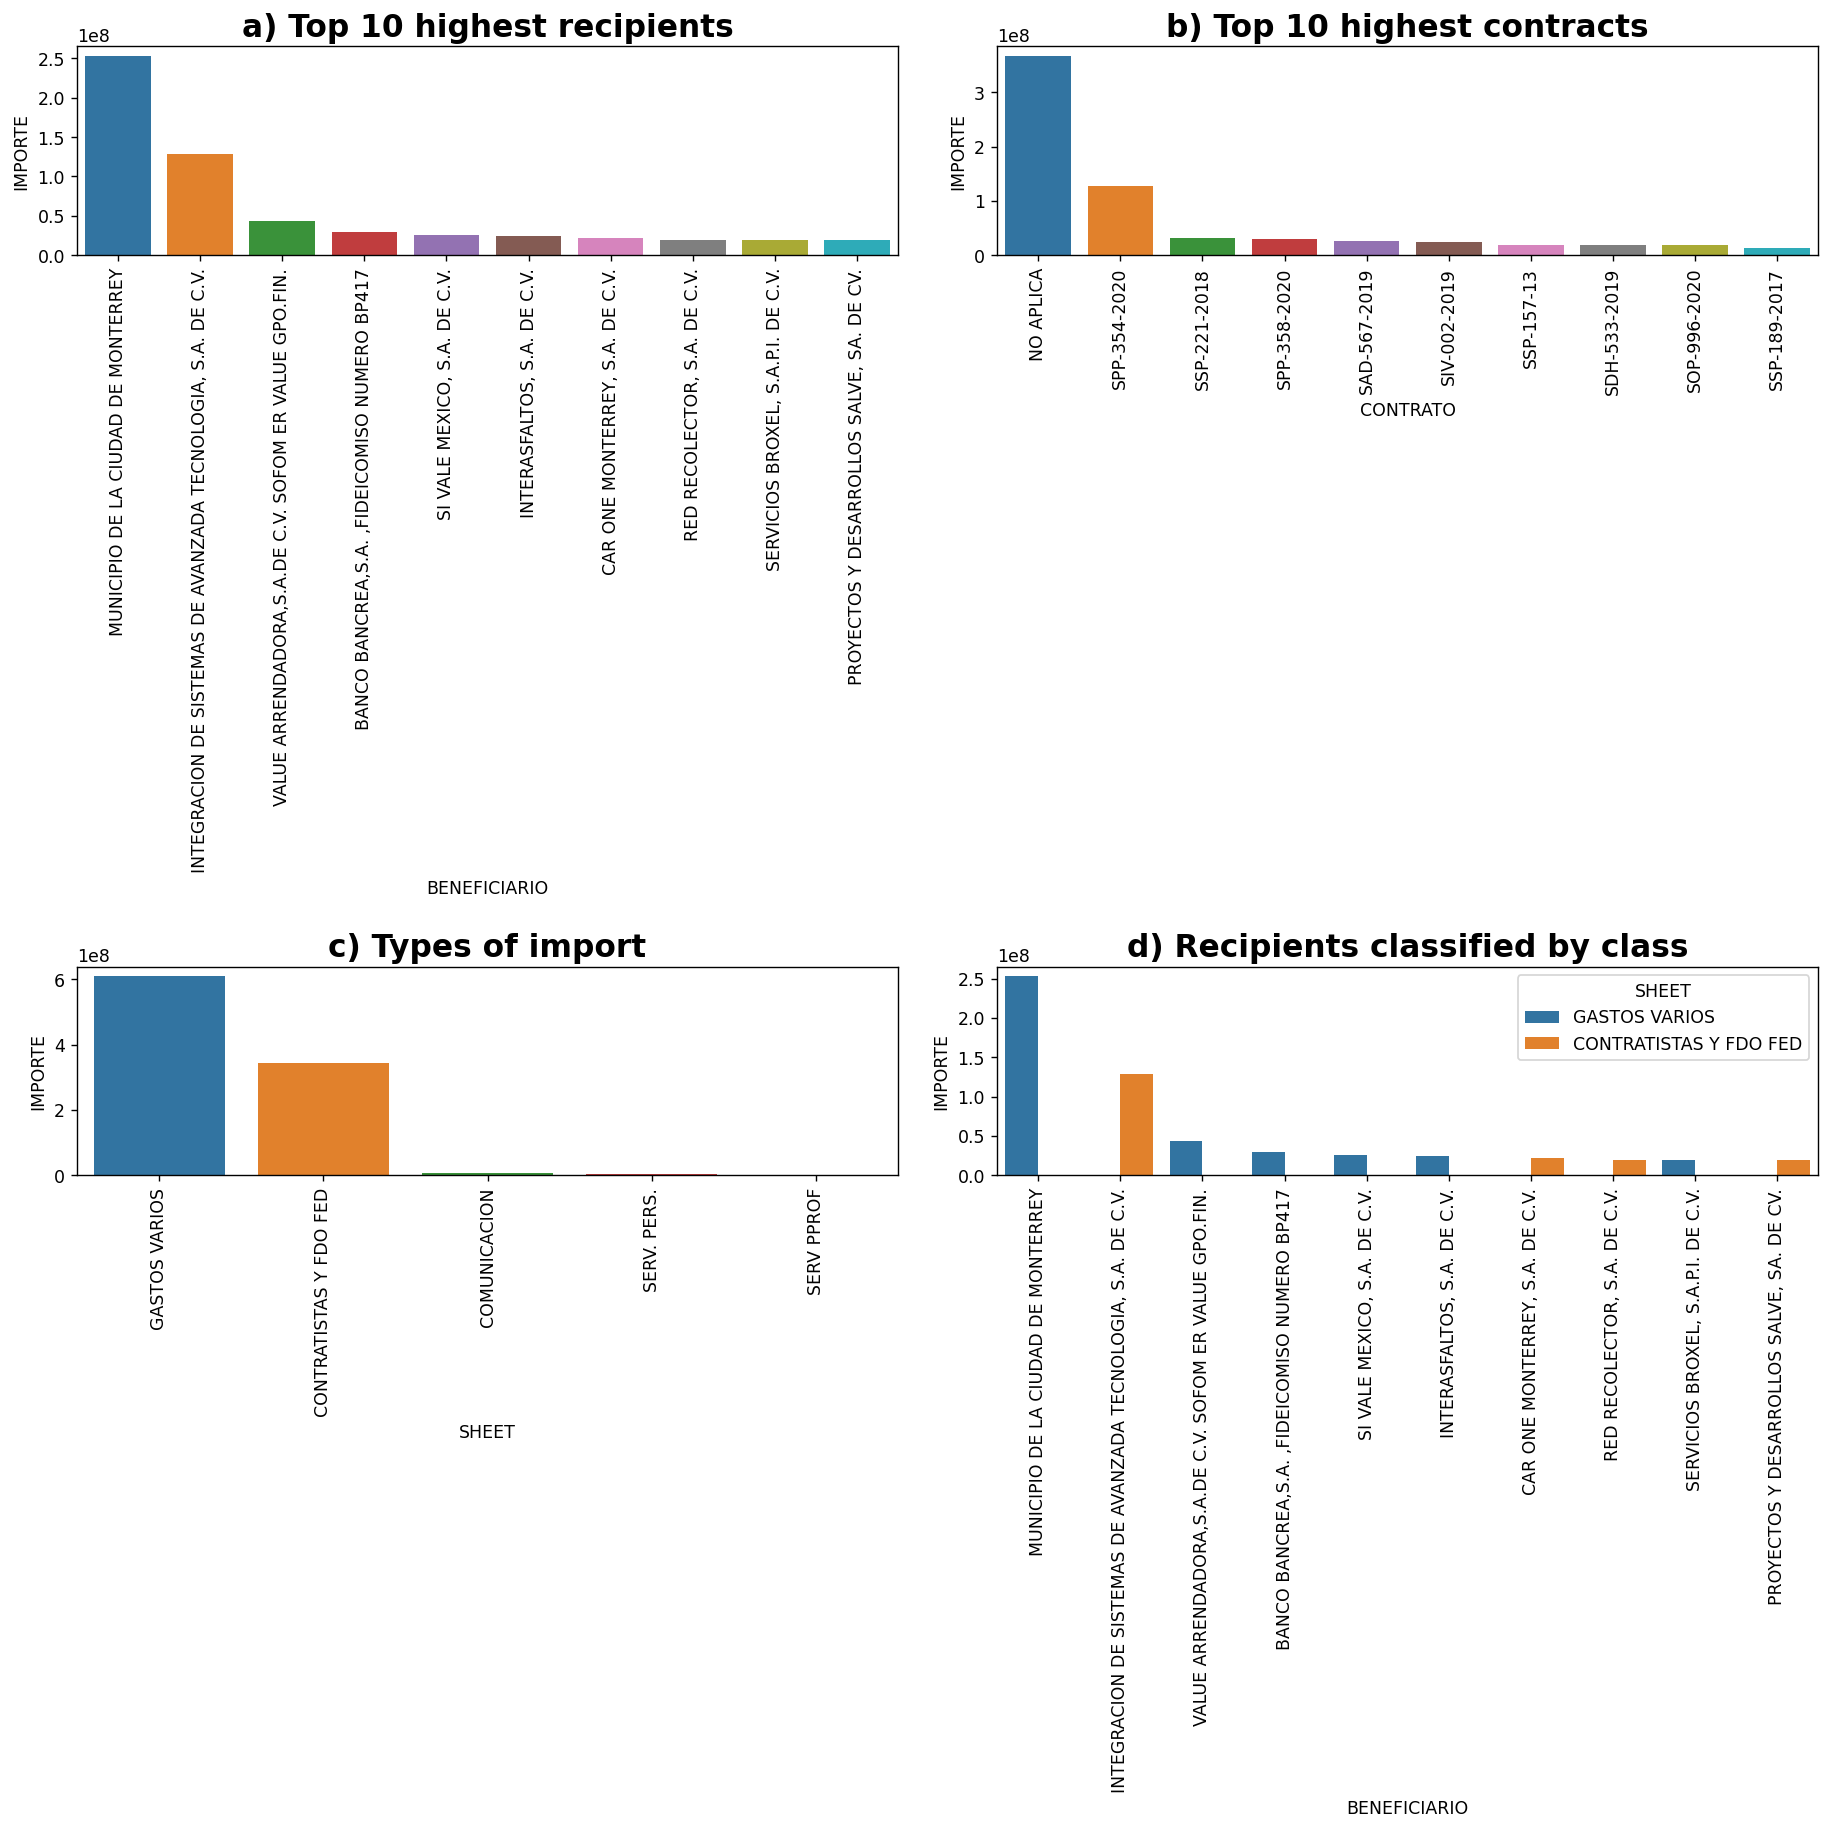

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15,15), dpi=125)
barplot(data=recipients, x="BENEFICIARIO", y="IMPORTE", ax=axes.flat[0])
barplot(data=contracts, x="CONTRATO", y="IMPORTE", ax=axes.flat[1])
barplot(data=concept_type, x="SHEET", y="IMPORTE", ax=axes.flat[2])
barplot(data=recipients, x="BENEFICIARIO", y="IMPORTE", ax=axes.flat[3], hue="SHEET")
axes.flat[0].set_xticklabels(recipients['BENEFICIARIO'], rotation=90)
axes.flat[0].set_title("a) Top 10 highest recipients", fontdict={'fontweight' : 'bold', 'fontsize' : 18})
axes.flat[1].set_xticklabels(contracts['CONTRATO'], rotation=90)
axes.flat[1].set_title("b) Top 10 highest contracts", fontdict={'fontweight' : 'bold', 'fontsize' : 18})
axes.flat[2].set_xticklabels(concept_type['SHEET'], rotation=90)
axes.flat[2].set_title("c) Types of import", fontdict={'fontweight' : 'bold', 'fontsize' : 18})
axes.flat[3].set_xticklabels(recipients["BENEFICIARIO"], rotation=90)
axes.flat[3].set_title("d) Recipients classified by class", fontdict={'fontweight' : 'bold', 'fontsize' : 18})
plt.tight_layout(pad=2.0)
plt.show()

Contracts were mostly given on 8th, and 17th december 2020.

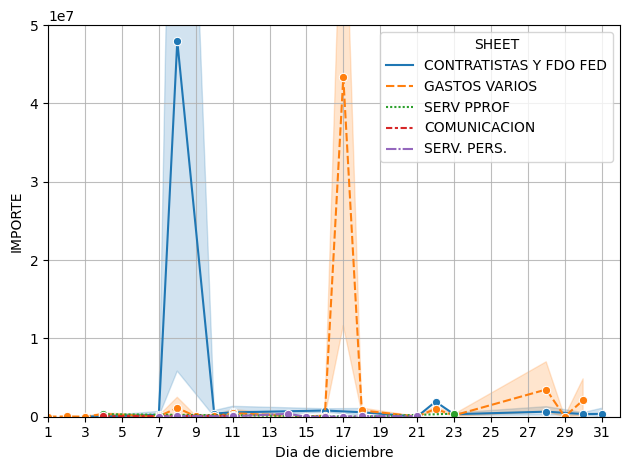

In [13]:
lineplot(
    data=treasury_purchases, 
    x="DIA", 
    y="IMPORTE", 
    hue="SHEET", 
    style="SHEET",
    marker="o"
)
plt.xlabel("Dia de diciembre")
plt.ylim(0, 0.5e8)
plt.xlim([1, 32])
plt.xticks(arange(1, 32, 2))
plt.grid(alpha=5/6)
plt.tight_layout()
plt.show()

### Text analysis

In [14]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [15]:
purchase_text = ""
for row in treasury_purchases["CONCEPTO"]:
    purchase_text = purchase_text + ' ' + row

In [16]:
stopwords_list = stopwords.words('spanish') + ['2020', 'cont', 'millar', 'dpp', 'est', 'op', 'ret', 'mty', 'icom', 'cp', 'r33 op', 'ret cont', 'ret  cont']

In [17]:
# For words that are not in stopwords and which length is longer than 4 letters.
purchase_text = ' '.join([x for x in purchase_text.strip().lower().split(' ') if x not in stopwords_list and len(x)>7])

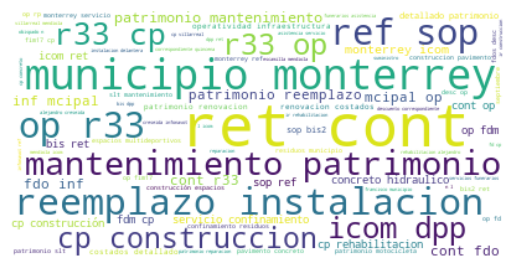

In [18]:
wc = WordCloud(background_color= 'white')
wc.generate(purchase_text)

plt.axis("off")
plt.imshow(wc, interpolation='bilinear')
plt.show()